# Image Classification: L1 vs L2 Distance



In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive
drive.mount('/content/drive')


DATASET_PATH = '/content/drive/My Drive/animal_dataset'
IMG_SIZE = (32, 32)
FOLDS = 5
K_VALUES = range(1, 21)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading and Preprocessing
We resize images to 32x32 to reduce dimensionality (1024 features) and convert to grayscale.


In [19]:
def load_and_preprocess_data(path):
    data = []
    labels = []
    class_names = []

    # Check if path exists
    if not os.path.exists(path):
        print(f"Error: Directory '{path}' not found.")
        return np.array([]), np.array([]), []

    # Get class names from subdirectories
    class_names = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    class_names.sort()

    print(f"Classes found: {class_names}")
    print("Loading and Preprocessing images...")

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(path, class_name)

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            # Read image
            img = cv2.imread(img_path)
            if img is None: continue

            # Preprocessing: Resize -> Grayscale -> Flatten
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Flatten image to 1D vector
            data.append(img.flatten())
            labels.append(class_idx)

    return np.array(data), np.array(labels), class_names

# Execution
X, y, classes = load_and_preprocess_data(DATASET_PATH)
print(f"Total images loaded: {len(X)}")
print(f"Feature vector shape: {X.shape if len(X) > 0 else 'N/A'}")


Classes found: ['cat', 'dog', 'panda']
Loading and Preprocessing images...
Total images loaded: 300
Feature vector shape: (300, 1024)


## 5-Fold Cross-Validation
We iterate through K values (1-20) and calculate the average accuracy across 5 folds for both distance metrics.


In [20]:
def run_cross_validation(X, y):
    if len(X) == 0: return None

    # Store average accuracies
    results = {'Manhattan (L1)': [], 'Euclidean (L2)': []}

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    print(f"Starting {FOLDS}-Fold Cross-Validation...")

    for k in K_VALUES:
        l1_scores = []
        l2_scores = []

        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Train Manhattan (p=1)
            knn_l1 = KNeighborsClassifier(n_neighbors=k, p=1, metric='minkowski')
            knn_l1.fit(X_train, y_train)
            l1_scores.append(accuracy_score(y_val, knn_l1.predict(X_val)))

            # Train Euclidean (p=2)
            knn_l2 = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
            knn_l2.fit(X_train, y_train)
            l2_scores.append(accuracy_score(y_val, knn_l2.predict(X_val)))

        # Average scores
        results['Manhattan (L1)'].append(np.mean(l1_scores))
        results['Euclidean (L2)'].append(np.mean(l2_scores))

    return results

# Execution
accuracy_results = run_cross_validation(X, y)


Starting 5-Fold Cross-Validation...


## Results and Visualization
Plotting K vs. Accuracy to identify the optimal hyperparameter and distance metric.


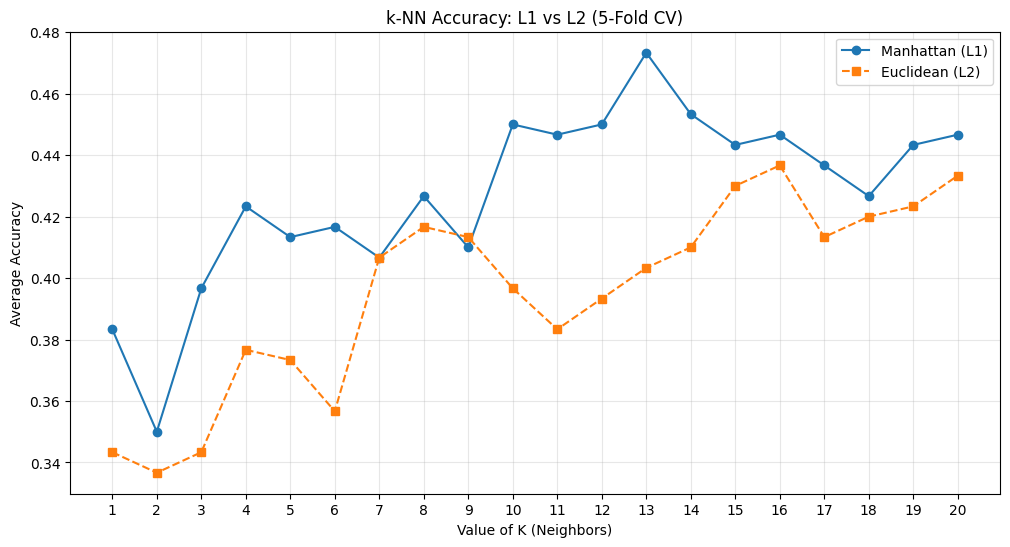

In [21]:
def visualize_results(results):
    if results is None: return

    plt.figure(figsize=(12, 6))
    plt.plot(K_VALUES, results['Manhattan (L1)'], marker='o', label='Manhattan (L1)', linestyle='-')
    plt.plot(K_VALUES, results['Euclidean (L2)'], marker='s', label='Euclidean (L2)', linestyle='--')

    plt.title(f'k-NN Accuracy: L1 vs L2 ({FOLDS}-Fold CV)')
    plt.xlabel('Value of K (Neighbors)')
    plt.ylabel('Average Accuracy')
    plt.xticks(K_VALUES)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

visualize_results(accuracy_results)


##Top 5 Predictions
Visualizing the model's performance on the first 5 samples of the dataset.


In [22]:
optimal_k = -1
optimal_metric = ''
max_accuracy = 0.0

if accuracy_results is not None:
    for idx, k in enumerate(K_VALUES):
        # Check Manhattan (L1) accuracy
        current_l1_accuracy = accuracy_results['Manhattan (L1)'][idx]
        if current_l1_accuracy > max_accuracy:
            max_accuracy = current_l1_accuracy
            optimal_k = k
            optimal_metric = 'Manhattan (L1)'

        # Check Euclidean (L2) accuracy
        current_l2_accuracy = accuracy_results['Euclidean (L2)'][idx]
        if current_l2_accuracy > max_accuracy:
            max_accuracy = current_l2_accuracy
            optimal_k = k
            optimal_metric = 'Euclidean (L2)'

    print(f"Optimal K value: {optimal_k}")
    print(f"Optimal Distance Metric: {optimal_metric}")
    print(f"Highest Average Accuracy: {max_accuracy:.4f}")
else:
    print("Accuracy results are not available. Please run the cross-validation step first.")

Optimal K value: 13
Optimal Distance Metric: Manhattan (L1)
Highest Average Accuracy: 0.4733


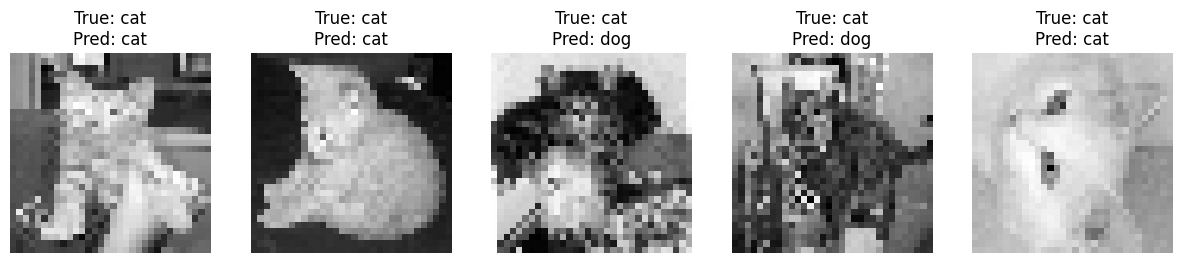

In [23]:
def show_top_predictions(X, y, class_names, optimal_k, optimal_metric):
    if len(X) == 0: return

    # Determine the distance metric parameter 'p'
    p_value = 1 if optimal_metric == 'Manhattan (L1)' else 2

    # Using the optimal K and optimal distance metric
    knn = KNeighborsClassifier(n_neighbors=optimal_k, p=p_value)
    knn.fit(X, y)

    predictions = knn.predict(X[:5])

    plt.figure(figsize=(15, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        # Reshape back to 32x32 for display
        img_display = X[i].reshape(IMG_SIZE)
        plt.imshow(img_display, cmap='gray')
        plt.title(f"True: {class_names[y[i]]}\nPred: {class_names[predictions[i]]}")
        plt.axis('off')
    plt.show()

# Call the function with optimal parameters
show_top_predictions(X, y, classes, optimal_k, optimal_metric)